In [ ]:
# Install libraries
!pip install optuna

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from optuna.pruners import MedianPruner
import matplotlib.pyplot as plt

# Automatically use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.5 MB/s eta 0:00:00
Using: cpu


In [ ]:
# Load and preprocess the dataset
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.drop("customerID", axis=1, inplace=True)
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0}) #convert target to binary
df = pd.get_dummies(df, drop_first=True) #one-hot encoding
df = df.apply(pd.to_numeric, errors="coerce").fillna(0) #numeric & fill missing

# Split features and target
X = df.drop("Churn", axis=1).astype("float32").values
y = df["Churn"].astype("float32").values

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# Create DataLoaders
batch_size = 256

train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    TensorDataset(X_val_tensor, y_val_tensor),
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [ ]:
df.head()

,SeniorCitizen,tenure,MonthlyCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,TotalCharges_995.35,TotalCharges_996.45,TotalCharges_996.85,TotalCharges_996.95,TotalCharges_997.65,TotalCharges_997.75,TotalCharges_998.1,TotalCharges_999.45,TotalCharges_999.8,TotalCharges_999.9
0,0,1,29.85,0,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0,34,56.95,0,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,2,53.85,1,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,45,42.30,0,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,0,2,70.70,1,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Define model
def create_model(trial):
    units1 = trial.suggest_int("units1", 64, 192, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4)
    units2 = trial.suggest_int("units2", 32, 128, step=32)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])

    model = nn.Sequential(
        nn.Linear(X_train.shape[1], units1),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(units1, units2),
        nn.ReLU(),
        nn.Linear(units2, 1),
        nn.Sigmoid()
    )

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    return model, optimizer


In [ ]:
# Objective function for Optuna to minimize validation loss
def objective(trial):
    model, optimizer = create_model(trial)
    model.to(device)

    loss_fn = nn.BCELoss()

    for epoch in range(40):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).squeeze()
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate validation loss after this epoch
        model.eval()
        with torch.no_grad():
            preds = model(X_val_tensor).squeeze()
            val_loss = loss_fn(preds, y_val_tensor)

        # Report progress to Optuna
        trial.report(val_loss.item(), step=epoch)

        # Allow Optuna to prune if performance is bad
        if trial.should_prune():
            raise optuna.TrialPruned()

    return val_loss.item()

In [ ]:
# Run Optuna optimization
study = optuna.create_study(direction="minimize",
pruner=MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=50)
# Print best trial info
print("Best Trial:")
best_trial = study.best_trial
print(f"- Validation Loss: {best_trial.value:.4f}")
print(f"- Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  • {key}: {value}")

[I 2025-03-31 02:36:24,999] A new study created in memory with name: no-name-b6c69a3d-388f-436d-ac54-ec9d7e76ba0b
[I 2025-03-31 02:37:53,450] Trial 0 finished with value: 0.6892408132553101 and parameters: {'units1': 160, 'dropout_rate': 0.3876316661321016, 'units2': 128, 'learning_rate': 4.3006891084651706e-05, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6892408132553101.
[I 2025-03-31 02:38:45,743] Trial 1 finished with value: 0.48741617798805237 and parameters: {'units1': 64, 'dropout_rate': 0.29297797439348977, 'units2': 96, 'learning_rate': 1.785418432905797e-05, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.48741617798805237.
[I 2025-03-31 02:39:35,181] Trial 2 finished with value: 0.4671204090118408 and parameters: {'units1': 64, 'dropout_rate': 0.36497111165679624, 'units2': 64, 'learning_rate': 2.5323398389762502e-05, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.4671204090118408.
[I 2025-03-31 02:40:46,800] Trial 3 finished with value: 1.142228841781616

Best Trial:
- Validation Loss: 0.4671
- Best Hyperparameters:
  • units1: 64
  • dropout_rate: 0.36497111165679624
  • units2: 64
  • learning_rate: 2.5323398389762502e-05
  • optimizer: RMSprop


<ipython-input-9-7dabcdf861a0>:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


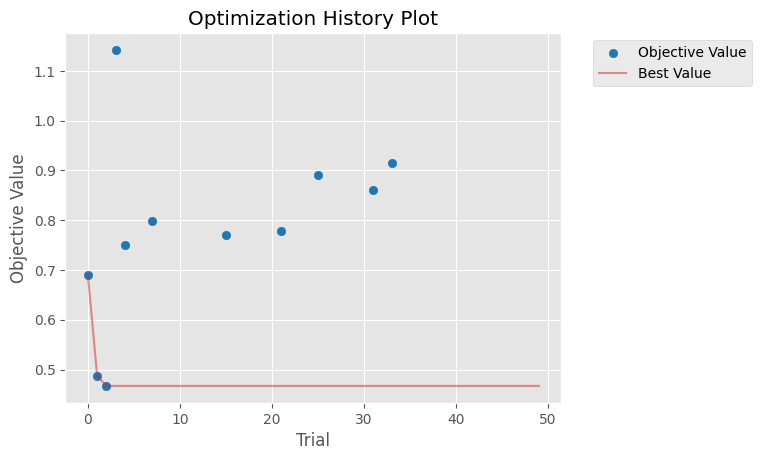

In [ ]:
# Visualize optimization results
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

<ipython-input-10-b56137fdf2d2>:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


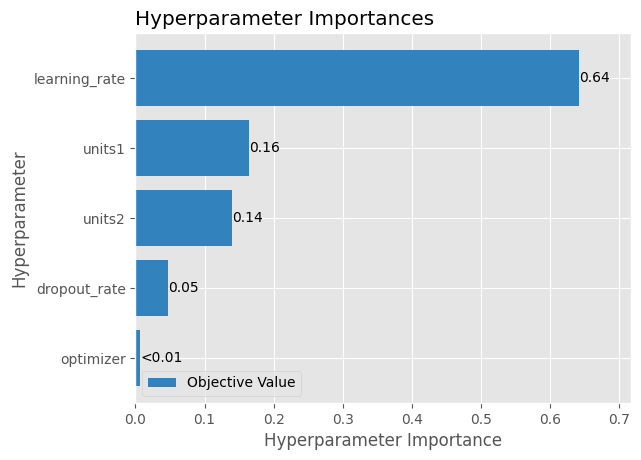

In [ ]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

In [ ]:
# Rebuild and retrain the best model to evaluate
best_params = study.best_params

# Define the final model using best hyperparameters
final_model = nn.Sequential(
    nn.Linear(X_train.shape[1], best_params["units1"]),
    nn.ReLU(),
    nn.Dropout(best_params["dropout_rate"]),
    nn.Linear(best_params["units1"], best_params["units2"]),
    nn.ReLU(),
    nn.Linear(best_params["units2"], 1),
    nn.Sigmoid()
)

# Select optimizer using best hyperparameter
if best_params["optimizer"] == "Adam":
    final_optimizer = optim.Adam(final_model.parameters(),
    lr=best_params["learning_rate"])
else:
    final_optimizer = optim.RMSprop(final_model.parameters(),
    lr=best_params["learning_rate"])

# Define loss function
loss_fn = nn.BCELoss()

In [ ]:
# Train the final model
final_model.to(device)
torch.manual_seed(42)

for epoch in range(40):
    final_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = final_model(xb).squeeze()
        loss = loss_fn(preds, yb)
        final_optimizer.zero_grad()
        loss.backward()
        final_optimizer.step()

In [ ]:
# Evaluate accuracy
final_model.eval()
with torch.no_grad():
    preds = final_model(X_val_tensor).squeeze()
    predicted = (preds >= 0.5).float()
    accuracy = (predicted == y_val_tensor).float().mean()
print(f"Final Accuracy: {accuracy:.4f}")

final_loss = loss_fn(preds, y_val_tensor)
print(f"Final Validation Loss: {final_loss:.4f}")

Final Accuracy: 0.7764
Final Validation Loss: 0.4636


In [ ]:
# Make predictions on validation set
final_model.eval()
with torch.no_grad():
    probs = final_model(X_val_tensor).squeeze().cpu().numpy()
    preds = (probs >= 0.5).astype(int)
    labels = y_val_tensor.cpu().numpy()


print("Evaluation Metrics")
print(f"Accuracy:  {accuracy_score(labels, preds):.4f}")
print(f"Precision: {precision_score(labels, preds):.4f}")
print(f"Recall:    {recall_score(labels, preds):.4f}")
print(f"F1 Score:  {f1_score(labels, preds):.4f}")
print(f"ROC AUC:   {roc_auc_score(labels, probs):.4f}")

Evaluation Metrics
Accuracy:  0.7764
Precision: 0.6855
Recall:    0.2914
F1 Score:  0.4090
ROC AUC:   0.8032
